In [54]:
! pip install coco-experiment cocopp scipy scikit-learn matplotlib seaborn pandas numpy ripser tqdm persim scikit-tda

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [scikit-tda]


# Dataset

In [53]:
suite = cocoex.Suite(
    "bbob",
    "",
    ("function_indices: 1-24 " "dimensions: 2 " "instance_indices: 100 "),
)
print(len(suite))

360


COCO WARNING: coco_string_parse_ranges(): 'instance_indices' ranges adjusted to be <= 15
COCO WARNING: coco_string_parse_ranges(): 'instance_indices' ranges not within boundaries; some ranges ignored
COCO WARNING: coco_string_parse_ranges(): 'instance_indices' ranges adjusted to be <= 15
COCO WARNING: coco_string_parse_ranges(): 'instance_indices' ranges not within boundaries; some ranges ignored


In [7]:
## Sampling a function
import numpy as np

n_samples = 1000
dimension = function_one.dimension

## Uniform sampling within the box [-5, 5]^dimension
X_uniform = np.random.uniform(-5, 5, size=(n_samples, dimension))


## Latin Hypercube Sampling within the box [-5, 5]^dimension
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=dimension)
X_lhs = sampler.random(n=n_samples)
X_lhs = qmc.scale(X_lhs, l_bounds=[-5] * dimension, u_bounds=[5] * dimension)

# Evaluate the function at the sampled points
Y_uniform = np.array([function_one(x) for x in X_uniform])
Y_lhs = np.array([function_one(x) for x in X_lhs])

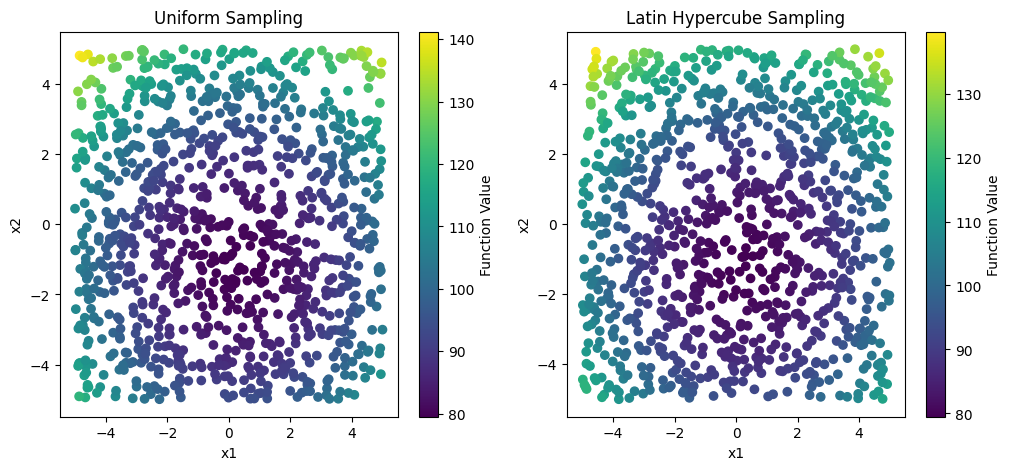

In [8]:
## Initial plots
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_uniform[:, 0], X_uniform[:, 1], c=Y_uniform, cmap="viridis")
plt.colorbar(label="Function Value")
plt.title("Uniform Sampling")
plt.xlabel("x1")
plt.ylabel("x2")
plt.subplot(1, 2, 2)
plt.scatter(X_lhs[:, 0], X_lhs[:, 1], c=Y_lhs, cmap="viridis")
plt.colorbar(label="Function Value")
plt.title("Latin Hypercube Sampling")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Transformation

In [55]:
from sklearn.decomposition import PCA


def axis_transform(X):
    pca = PCA(n_components=X.shape[1])
    centered_points = pca.fit_transform(X)

    min_vals = centered_points.min(axis=0)
    max_vals = centered_points.max(axis=0)

    ## from source code:
    scaled = centered_points / np.abs(centered_points).max(axis=0)
    # # Scale to [-1, 1]
    # X_scaled = np.zeros_like(centered_points)
    # for dim in range(centered_points.shape[1]):
    #     min_val = min_vals[dim]
    #     max_val = max_vals[dim]
    #     if max_val > min_val:
    #         X_scaled[:, dim] = (
    #             2 * (centered_points[:, dim] - min_val) / (max_val - min_val) - 1
    #         )
    #     else:
    #         X_scaled[:, dim] = 0

    return scaled


def volume_transform(X):
    _, n_dimensions = X.shape

    pca = PCA(n_components=n_dimensions)
    centered_points = pca.fit_transform(X)

    min_vals = centered_points.min(axis=0)
    max_vals = centered_points.max(axis=0)

    # Bounding box dimensions along each axis
    box_dimensions = max_vals - min_vals

    current_hypervolume = np.prod(box_dimensions)

    if current_hypervolume > 0:
        scale_factor = (1.0 / current_hypervolume) ** (1.0 / n_dimensions)
    else:
        scale_factor = 1.0

    X_scaled = centered_points * scale_factor
    return X_scaled

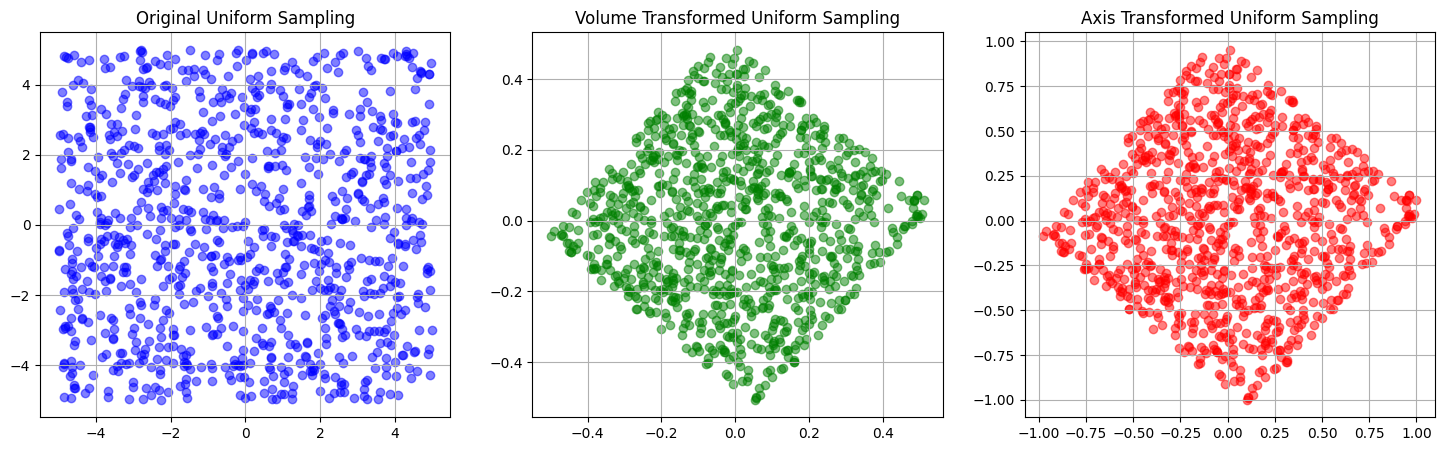

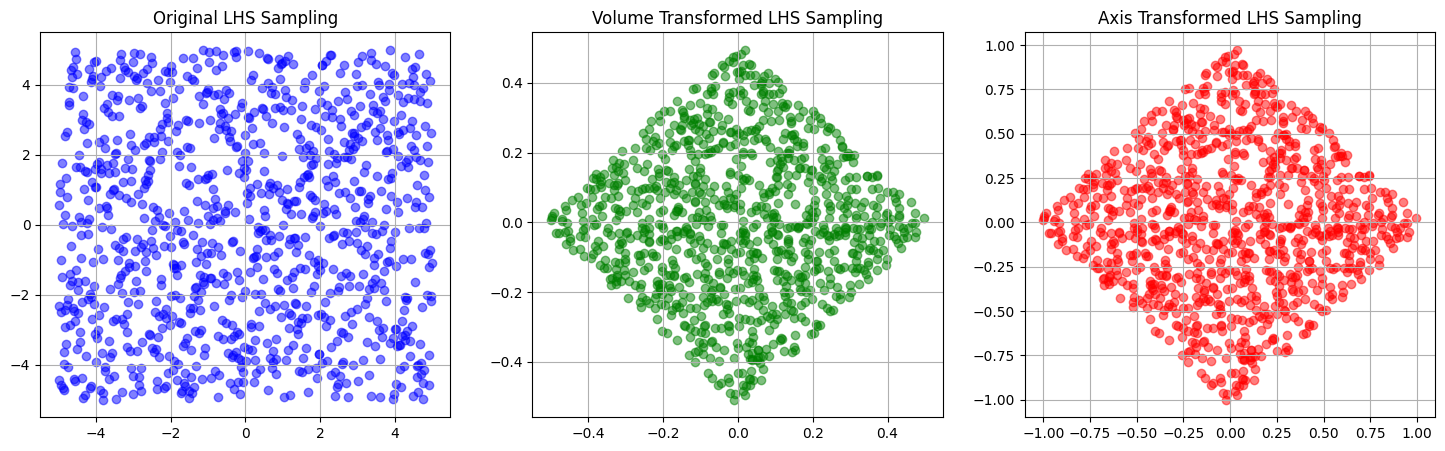

In [56]:
X_uniform_volume = volume_transform(X_uniform)
X_lhs_volume = volume_transform(X_lhs)

X_uniform_axis = axis_transform(X_uniform)
X_lhs_axis = axis_transform(X_lhs)

transformation_plot = plt.subplots(1, 3, figsize=(18, 5))
transformation_plot[1][0].scatter(
    X_uniform[:, 0], X_uniform[:, 1], c="blue", alpha=0.5, label="Original"
)
transformation_plot[1][0].set_title("Original Uniform Sampling")
transformation_plot[1][0].grid(True)
transformation_plot[1][1].scatter(
    X_uniform_volume[:, 0],
    X_uniform_volume[:, 1],
    c="green",
    alpha=0.5,
    label="Volume Transformed",
)
transformation_plot[1][1].set_title("Volume Transformed Uniform Sampling")
transformation_plot[1][1].grid(True)
transformation_plot[1][2].scatter(
    X_uniform_axis[:, 0],
    X_uniform_axis[:, 1],
    c="red",
    alpha=0.5,
    label="Axis Transformed",
)
transformation_plot[1][2].set_title("Axis Transformed Uniform Sampling")
transformation_plot[1][2].grid(True)
plt.show()

tr_plot_lhs = plt.subplots(1, 3, figsize=(18, 5))
tr_plot_lhs[1][0].scatter(
    X_lhs[:, 0], X_lhs[:, 1], c="blue", alpha=0.5, label="Original"
)
tr_plot_lhs[1][0].set_title("Original LHS Sampling")
tr_plot_lhs[1][0].grid(True)
tr_plot_lhs[1][1].scatter(
    X_lhs_volume[:, 0],
    X_lhs_volume[:, 1],
    c="green",
    alpha=0.5,
    label="Volume Transformed",
)
tr_plot_lhs[1][1].set_title("Volume Transformed LHS Sampling")
tr_plot_lhs[1][1].grid(True)
tr_plot_lhs[1][2].scatter(
    X_lhs_axis[:, 0], X_lhs_axis[:, 1], c="red", alpha=0.5, label="Axis Transformed"
)
tr_plot_lhs[1][2].set_title("Axis Transformed LHS Sampling")
tr_plot_lhs[1][2].grid(True)
plt.show()

## Pairwise Distance

In [57]:
## Pairwise distance matrix
from scipy.spatial.distance import pdist, squareform

distances_uniform = pdist(X_uniform, metric="euclidean")
X_D_uniform = squareform(distances_uniform)
Y_D_uniform = squareform(pdist(Y_uniform.reshape(-1, 1), metric="euclidean"))

distances_lhs = pdist(X_lhs, metric="euclidean")
X_D_lhs = squareform(distances_lhs)
Y_D_lhs = squareform(pdist(Y_lhs.reshape(-1, 1), metric="euclidean"))

In [58]:
## Pairwise distance matrix normalization
X_D_uniform_norm = X_D_uniform / np.max(distances_uniform)
X_D_lhs_norm = X_D_lhs / np.max(distances_lhs)
Y_D_uniform_norm = Y_D_uniform / np.max(Y_D_uniform)
Y_D_lhs_norm = Y_D_lhs / np.max(Y_D_lhs)

In [59]:
## Distance between sample
def get_distance(X_D, Y_D, alpha=0.2):
    return alpha * X_D + (1 - alpha) * Y_D

In [61]:
## Recreating 1-10 cosine similarity heatmap
alpha = 0.2
suite = cocoex.Suite(
    "bbob",
    "year: 2022",
    ("function_indices: 1-24 " "dimensions: 2 " "instance_indices: 1-15 "),
)
suite.get_problem(15).info

'bbob_f002_i01_d02: a 2-dimensional single-objective problem (problem 15 of suite "b\'bbob\'" with name "BBOB suite problem f2 instance 1 in 2D")'

In [62]:
from ripser import Rips
from tqdm.auto import tqdm
from persim import PersistenceImager

Xs = []
Ys = []
persistence_diagrams = []
kernel_size = 0.0002
max_range = 1.0
images0 = []
images1 = []
images2 = []

pimgr0 = PersistenceImager(
    pixel_size=0.01,
    birth_range=(0.0, 0.01),
    pers_range=(0.0, max_range),
    kernel_params={"sigma": [[kernel_size, 0.0], [0.0, kernel_size]]},
)
pimgr1 = PersistenceImager(
    pixel_size=0.01,
    birth_range=(0.0, max_range),
    pers_range=(0.0, max_range),
    kernel_params={"sigma": [[kernel_size, 0.0], [0.0, kernel_size]]},
)
pimgr2 = PersistenceImager(
    pixel_size=0.01,
    birth_range=(0.0, max_range),
    pers_range=(0.0, max_range),
    kernel_params={"sigma": [[kernel_size, 0.0], [0.0, kernel_size]]},
)


for problem in tqdm(suite):
    # Random Sampling
    X = np.random.uniform(-5, 5, size=(200, 2))
    X_transformed = X

    # Apply Transformation (Axis/Volume)
    X_transformed = X_transformed / np.abs(X_transformed).max(axis=0)
    X_D = squareform(pdist(X_transformed, metric="euclidean"))
    X_D_norm = X_D / np.abs(X_D).max(axis=0)

    Y = np.array([problem(x) for x in X_transformed])
    # Y = ( Y- Y.min() ) / ( Y.max() - Y.min() ) # min-max normalization [0,1]
    Y_D = squareform(pdist(Y.reshape(-1, 1), metric="euclidean"))
    Y_D_norm = Y_D / np.abs(Y_D).max(axis=0)

    Xs.append(X_D_norm)
    Ys.append(Y_D_norm)

    rips = Rips(maxdim=2, coeff=2, verbose=False)
    distances = get_distance(X_D_norm, Y_D_norm, alpha=alpha)
    diagrams = rips.fit_transform(distances, distance_matrix=True)

    d0 = diagrams[0]
    d1 = diagrams[1]
    d2 = diagrams[2]

    sel0 = np.isfinite(d0.sum(axis=1))
    sel1 = np.isfinite(d1.sum(axis=1))
    sel2 = np.isfinite(d2.sum(axis=1))

    img0 = pimgr0.transform(d0[sel0, :])
    img1 = pimgr1.transform(d1[sel1, :])
    img2 = pimgr2.transform(d2[sel2, :])

    images0.append(img0.flatten())
    images1.append(img1.flatten())
    images2.append(img2.flatten())

100%|██████████| 360/360 [01:43<00:00,  3.46it/s]


In [63]:
from sklearn.metrics.pairwise import cosine_similarity

sim0 = cosine_similarity(images0)
sim1 = cosine_similarity(images1)
sim2 = cosine_similarity(images2)
sim0.shape

(360, 360)

In [64]:
def plot_cosine_similarity_heatmap(
    sim, group_size=15, title="Cosine Similarity Heatmap", grid=True, vmin=0.9, vmax=1.0
):
    n_items = sim.shape[0]
    n_groups = n_items // group_size

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(sim, cmap="viridis", aspect="auto", vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax, label="Cosine Similarity")
    # ax.set_xticks(range(n_items))
    # ax.set_yticks(range(n_items))
    # ax.set_xticklabels(range(1, n_items + 1), fontsize=8)
    # ax.set_yticklabels(range(1, n_items + 1), fontsize=8)
    ax2 = ax.secondary_xaxis("top")
    # ax3 = ax.secondary_yaxis("right")

    group_positions = [i * group_size + group_size / 2 - 0.5 for i in range(n_groups)]
    group_labels = [f"{i+1}" for i in range(n_groups)]

    ax.set_xticks([])

    ax2.set_xticks(group_positions)
    ax2.set_xticklabels(group_labels, fontsize=12, fontweight="bold")

    ax.set_yticks(group_positions)
    ax.set_yticklabels(group_labels, fontsize=12, fontweight="bold")

    # Add grid lines to separate groups
    if grid:
        for i in range(1, n_groups):
            ax.axhline(i * group_size - 0.5, color="white", linewidth=2)
            ax.axvline(i * group_size - 0.5, color="white", linewidth=2)

    # ax.set_xlabel("Instance", fontsize=12)
    ax.set_ylabel("Function", fontsize=12)
    ax2.set_xlabel("Function", fontsize=12)
    ax.set_title(title, fontsize=14, pad=20)

    plt.tight_layout()
    plt.show()

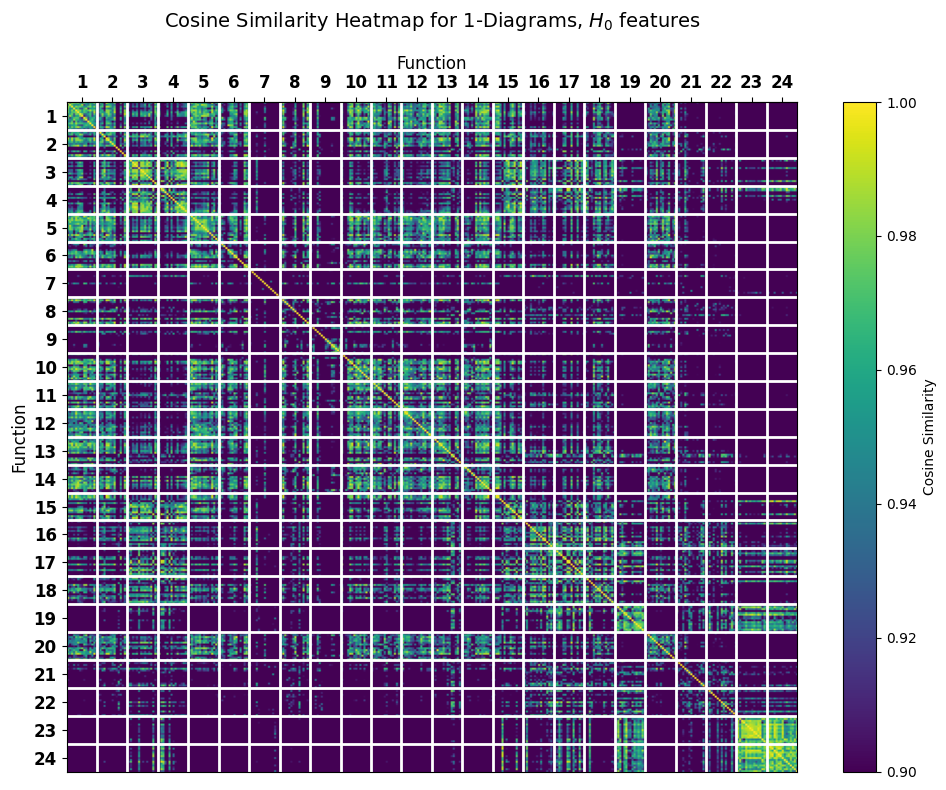

In [68]:
plot_cosine_similarity_heatmap(
    sim1, title="Cosine Similarity Heatmap for 1-Diagrams, $H_0$ features", vmin=0.90
)

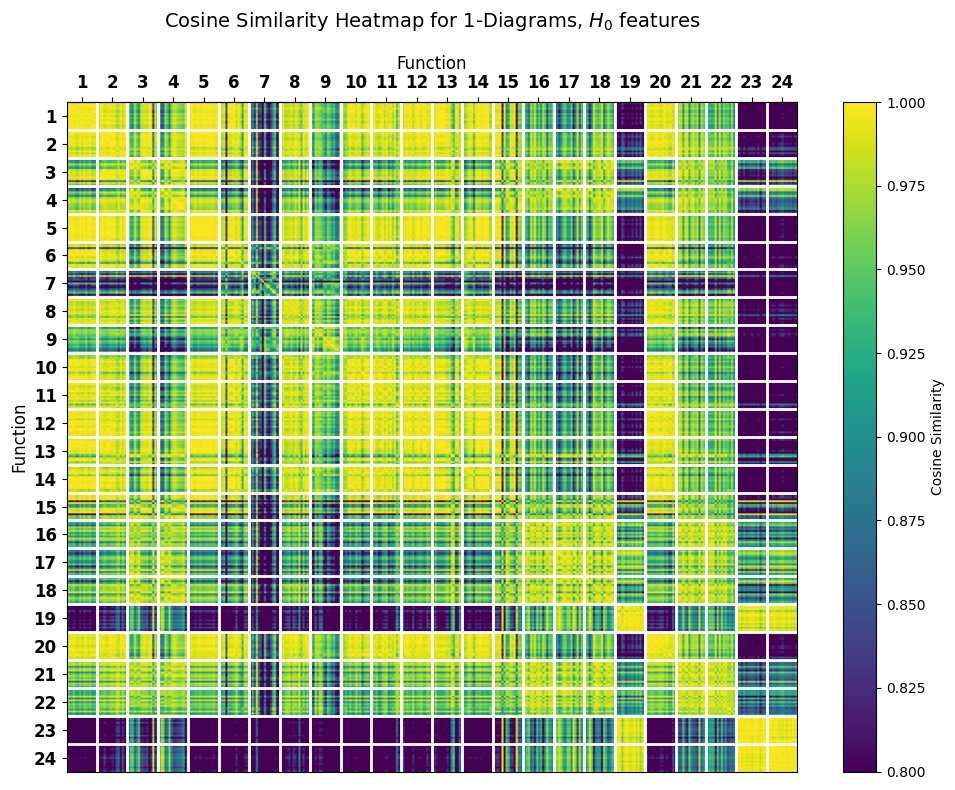

In [66]:
plot_cosine_similarity_heatmap(
    sim0, title="Cosine Similarity Heatmap for 1-Diagrams, $H_0$ features", vmin=0.8
)

In [72]:
image_concat = np.column_stack((images0, images1))
sim_concat = cosine_similarity(image_concat)

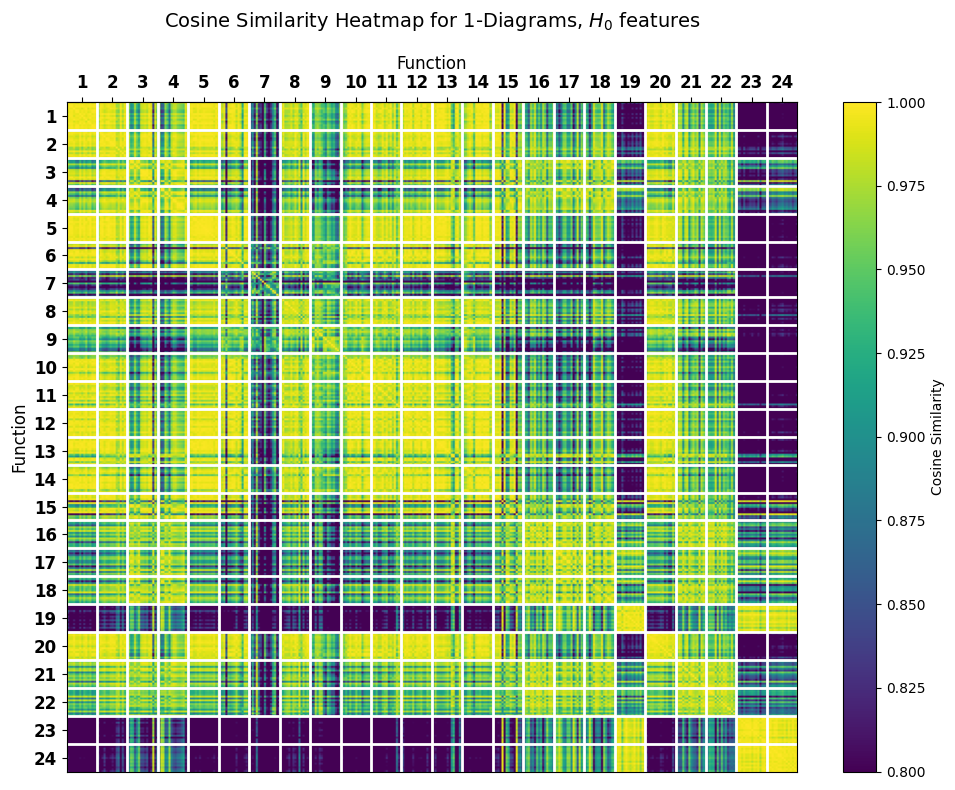

In [73]:
plot_cosine_similarity_heatmap(
    sim_concat,
    title="Cosine Similarity Heatmap for 1-Diagrams, $H_0$ features",
    vmin=0.8,
)